SHAFAQ JAVED BAJWA                                                          Student id: 21031878

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import sklearn.cluster as cluster

In [2]:
def read_wbdata(filename):
    '''
    Returns two dataframes one with country as columns and the other with years as columns
    '''
    df = pd.read_excel(filename,skiprows=3)
    yrs_df = df.set_index('Country Name').drop(labels=['Country Code', 'Indicator Name','Indicator Code'],axis=1)
    cou_df = yrs_df.transpose()
    return yrs_df, cou_df

In [3]:
def remove_outlier(df_in, col_name):
    '''
    Removes outliers from the data using iterquartile method
    '''
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out


In [4]:
def normalize(v):
    '''
    Min max scales the data
    '''
    return (v - v.min()) / (v.max() - v.min())

In [5]:
def err_ranges(x, func, param, sigma):
    """
    Calculates the upper and lower limits for the function, parameters and
    sigmas for single value or array x. Functions values are calculated for 
    all combinations of +/- sigma and the minimum and maximum is determined.
    Can be used for all number of parameters and sigmas >=1.
    
    This routine can be used in assignment programs.
    """

    import itertools as iter
    
    # initiate arrays for lower and upper limits
    lower = func(x, *param)
    upper = lower
    
    uplow = []   # list to hold upper and lower limits for parameters
    for p,s in zip(param, sigma):
        pmin = p - s
        pmax = p + s
        uplow.append((pmin, pmax))
        
    pmix = list(iter.product(*uplow))
    
    for p in pmix:
        y = func(x, *p)
        lower = np.minimum(lower, y)
        upper = np.maximum(upper, y)
        
    return lower, upper   

In [6]:
def make_clusters(ser1,ser2,n_clusters=3,column_names=[0,1]):
    '''
    Makes clusters of data and plots the clusters
    '''
    df = pd.concat([ser1, ser2], axis=1,keys=column_names).dropna()
    df = remove_outlier(df,column_names[0])
    df = remove_outlier(df,column_names[1])
    kmeans = cluster.KMeans(n_clusters=n_clusters)
    x = df[column_names[0]].values.reshape(-1, 1)
    y = df[column_names[1]].values
    kmeans.fit(normalize(x),normalize(y))#normalized values are used to cluster
    cen = kmeans.cluster_centers_
    labels = kmeans.labels_
    col = ["blue", "red", "green","orange","black"]
    for l in range(len(cen)): # loop over the different labels
        plt.plot(x[labels==l], y[labels==l], "o", markersize=3, color=col[l])
    plt.xlabel(column_names[0])
    plt.ylabel(column_names[1])
    
    plt.show()

In [7]:
pop1,pop2 = read_wbdata('API_SP.POP.GROW_DS2_en_excel_v2_4007664.xls')

In [8]:
co1,co2 = read_wbdata('API_EN.ATM.GHGT.KT.CE_DS2_en_excel_v2_4026021.xls')

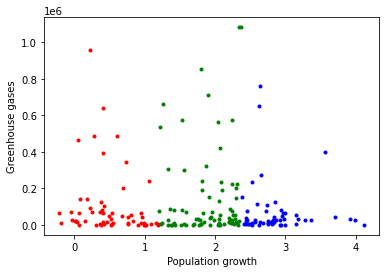

In [9]:
make_clusters(pop2.mean(), co2.mean(),column_names=['Population growth', 'Greenhouse gases'])

The above diagram show clusters of population growth wrt greenhouse gases. The clusters are made of less growing countries, growing countries and fast growing coutries. We can generally observe that growing coutries have the highest greenhouse footprint followed by less growing countries and then fast growing countries.

In [10]:
enr1,enr2 = read_wbdata('API_SE.ENR.PRSC.FM.ZS_DS2_en_excel_v2_4033821.xls')

In [11]:
mor1,mor2 = read_wbdata('API_SH.DYN.MORT_DS2_en_excel_v2_4030824.xls')

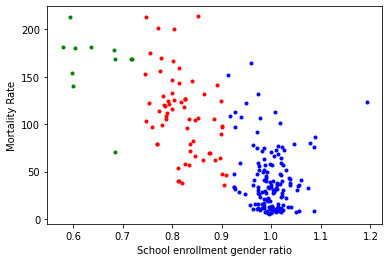

In [12]:
make_clusters(enr2.mean(), mor2.mean(),column_names=['School enrollment gender ratio', 'Mortality Rate'])

The above plot shows clusters made of health and education data. The indicators used are mortality rate and school enrollment gender ratio. The clusters are made of countries with near equal gender ratio, slightly inequal enrollment and very inequal enrollment. We can observe that the more equal the gender ratio the less the mortality rate is. 

In [13]:
def logistic(t, n0, g, t0,b):
    """Calculates the logistic function with scale factor n0 and growth rate g"""
    
    f = n0 / (1 + np.exp(-g*(t - t0))) + b
    
    return f

In [14]:
def fit_time(func, x_values,y_values,p0=None,error=True,xlabel = None,ylabel=None):
    '''
    optimized the given function for the given x and y values using the optim function
    and plots the predicted values and error ranges of the data + the next 10 years
    '''
    popt, pcov = curve_fit(func, x_values, y_values,p0=p0,maxfev = 5000)
    y_pred = func(range(x_values[0],x_values[-1]+10),*popt)
    sigma = np.sqrt(np.diag(pcov))
    low, up = err_ranges(range(x_values[0],x_values[-1]+10), func, popt, sigma)
    plt.plot(range(x_values[0],x_values[-1]+10),y_pred)
    plt.plot(x_values,y_values)
    if error:
        plt.fill_between(range(x_values[0],x_values[-1]+10), low, up, color="yellow", alpha=0.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(['predicted', 'original'])
    
    plt.show()

In [15]:
eng1,eng2 = read_wbdata('API_EG.USE.PCAP.KG.OE_DS2_en_excel_v2_4027677.xls')
x_values = np.array([int(x) for x in  eng2['China'].dropna().index])
y_values = eng2['China'].dropna().values

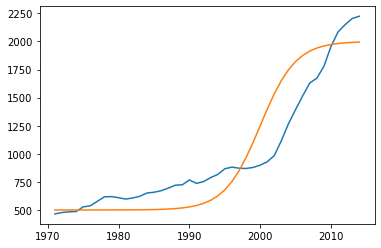

In [16]:
plt.plot(x_values,y_values)
plt.plot(x_values,logistic(x_values,1500,0.4,2000,500))

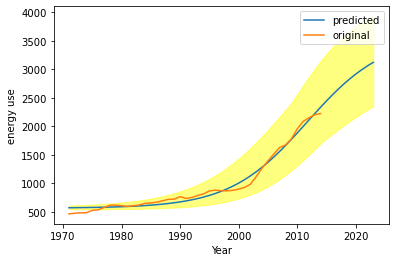

In [17]:
fit_time(logistic,x_values,y_values,(1500,0.4,2000,500),xlabel='Year',ylabel='energy use')

In [18]:
x_values = np.array([int(x) for x in  pop2['China'].dropna().index])
y_values = pop2['China'].dropna().values

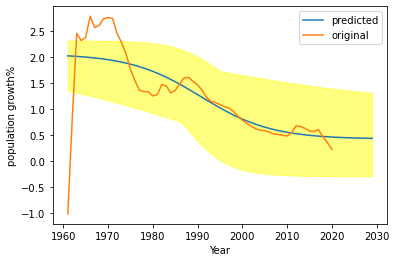

In [19]:
fit_time(logistic,x_values,y_values,(3e12, 0.03, 2000.0,0),xlabel='Year',ylabel='population growth%')